In [1]:
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from vit_keras.vit import vit_l32  # keep this line for VIT model!

2023-06-27 20:43:07.819822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hjj/anaconda3/envs/food-recognition/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
FOOD_PATH = "food/"
FOOD_DIR = glob.glob("food/*")
CATEGORIES_PATH = "categories.csv"

MODELS = ["sg-food-233-vitb32", "sg-food-233-xception", "sg-food-233-densenet121", "sg-food-233-densenet201",
          "sg-food-233-resnet152v2", "sg-food-233-inceptionv3", "sg-food-233-inceptionresnetv2"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

IMAGE_SIZE = 512
TOP_N = 5

In [3]:
categories = list(pd.read_csv(CATEGORIES_PATH, header=None)[0])

In [4]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [5]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [6]:
models = load_models()

Models Loaded


In [7]:
def predict(model, filepath, top_n=None):
    test_image = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    test_image_array = img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)
    test_image_array = test_image_array / 255.
    prediction = model.predict(test_image_array, verbose=0)
    if top_n:
        predicted_label = np.argsort(prediction[0])[::-1][:top_n]
    else:
        predicted_label = np.argsort(prediction[0])[::-1]
    predicted_score = prediction[0][predicted_label]
    return predicted_label, predicted_score

In [8]:
def ensemble_predict(filepath, top_n=None):
    predictions = {}
    for model in models:
        predicted_labels, predicted_scores = predict(model, filepath)
        for i, label in enumerate(predicted_labels):
            if categories[predicted_labels[i]] in predictions:
                if predictions[categories[predicted_labels[i]]] < predicted_scores[i]:
                    predictions[categories[predicted_labels[i]]] = predicted_scores[i]
            else:
                predictions[categories[predicted_labels[i]]] = predicted_scores[i]
    if top_n:
        predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True)[:top_n])
    else:
        predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))
    return predictions

food/sample13.jpg
Pilaf, pea
{'Pilaf, pea': 0.9951233, 'chicken masala': 0.4341639, 'paella seafood': 0.25498962, 'fried rice': 0.090909824, 'Bee hoon, goreng': 0.064468645}
food/chicken rice.jpg
chicken rice
{'chicken rice': 0.9999939, 'char siew': 0.02026512, 'Duck Rice': 0.008804538, 'yam rice': 0.007237858, 'nasi lemak': 0.0046091164}
food/sample12.jpg
Claypot Rice
{'Claypot Rice': 0.9986093, 'Barley': 0.021948397, 'muesli': 0.01390923, 'buckwheat': 0.011725592, 'Lor mee': 0.010581644}
food/test5.jpg
milk
{'milk': 0.98270696, 'Sweets': 0.959975, 'Chocolate': 0.73347723, 'Alcoholic Beverage': 0.2014189, 'orange': 0.12329376}
food/sample10.jpg
chicken soup
{'chicken soup': 0.80921793, 'bak kut teh': 0.623872, 'pig organ soup': 0.38466844, 'mushroom soup': 0.11938426, 'Miso ramen, with fishcake': 0.111823976}
food/sample11.jpg
fried chicken
{'fried chicken': 0.7448761, 'har cheong gai': 0.5334364, 'vadai': 0.23273315, 'Nuts': 0.16211942, 'fried prawn': 0.099052414}
food/test4.png
chic

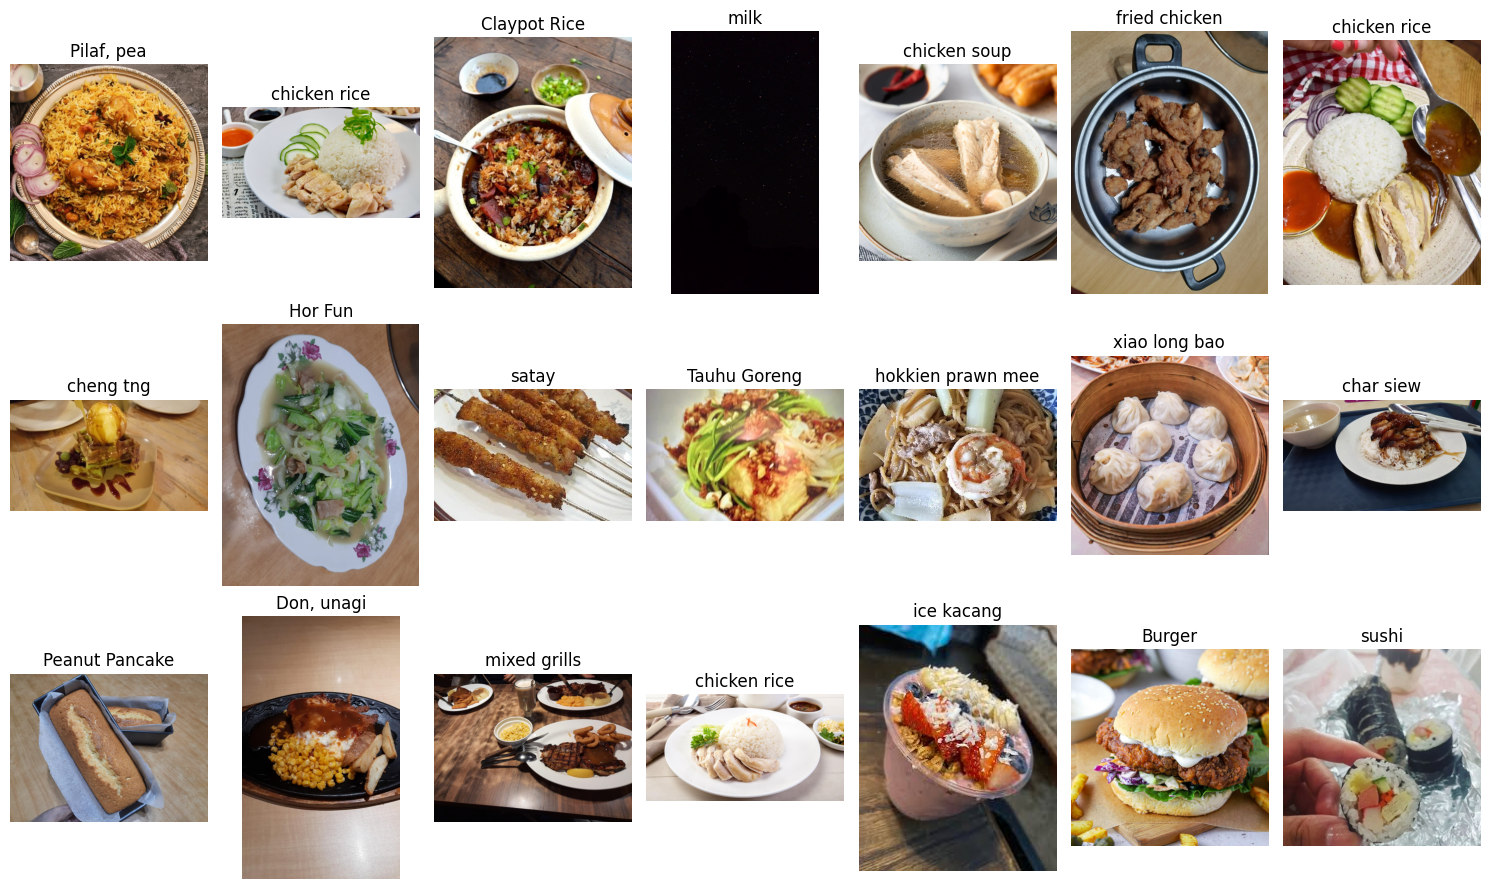

In [9]:
plt.figure(figsize=(15, 9))

size = 0
for food in FOOD_DIR:
    if ".md" in food or ".1." in food:
        continue
    size += 1

idx = 0
for food in FOOD_DIR:
    if ".md" in food or ".1." in food:
        continue
    pred = ensemble_predict(food, TOP_N)
    plt.subplot(3, math.ceil(size // 3), idx + 1)
    print(food)
    img = plt.imread(food)
    plt.title(list(pred.keys())[0])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    print("=" * 50)
    print(list(pred.keys())[0])
    print(pred)
    print("=" * 50)
    idx += 1
plt.tight_layout()